# Fragment library analysis

## Aim of this notebook

This notebook contains the code that was used to calculate most of the statistics as well as to generate the respective plots shown in the manuscript. 

## Table of contents

1. Fragment library
2. Original ligands
3. Ligand occupancy across subpockets
4. Subpocket connectivity across subpockets
5. Fragment occurrence per subpocket
6. Fragment properties per subpocket
7. Fragment similarity per subpocket
8. Fragment promiscuity
9. Draw ligand and fragments for GitHub README figure

In [1]:
%load_ext autoreload
%autoreload 2

Install the Table of Contents extension for JupyterLab for easy navigation through this notebook: https://github.com/jupyterlab/jupyterlab-toc

In [2]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools

from util import *

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
PATH_DATA = Path('.') / '..' / 'data'

## 1. Fragment library

### Load fragment library

Let's load the fragment library (in different formats for different kind of analysis later on):

- `fragment_library`: Dictionary of fragments (values as DataFrame) by subpockets (keys).
- `fragment_library_concat`: All fragments in one DataFrame.
- `fragment_library_concat_wo_x`: All fragments except fragments from pool X in one DataFrame.

**Load fragment library's subpocket pools**

`fragment_library` is a dictionary of fragments (values) per subpocket (keys)

The following data is linked to each fragment:

- PDB complex and ligand ID, alternate model and chain for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- Kinase name, family and group of the kinase the ligand (from which the fragment originates) was co-crystallized with
- Subpockets for each of the fragment's atoms (including the dummy atom's subpockets which show the connection of the fragment to neighboring pockets)
- BRICS environment IDs for each of the fragment's atoms
- Fragment's RDKit molecule (remote KLIFS access) and SMILES (generated from RDKit molecule)

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])
Example fragments for subpocket AP:


,ROMol,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles
0,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12
1,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1

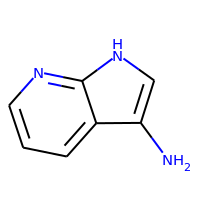
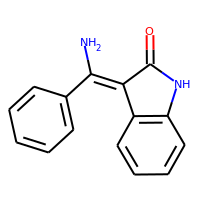

In [5]:
# Get fragment library by subpocket
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

print(fragment_library.keys())
print(f'Example fragments for subpocket AP:')
fragment_library['AP'].head(2)

**Load fragment library in one DataFrame**

`fragment_library_concat` is a DataFrame containing all subpocket pools from `fragment_library` with an additional column:

- Subpocket occupied by the fragment
- Fragment's SMILES with dummy atoms

In [6]:
fragment_library_concat = pd.read_csv('../data/fragment_library/fragment_library.csv')
PandasTools.AddMoleculeColumnToFrame(fragment_library_concat, 'smiles')

`fragment_library_concat_wo_x` is `fragment_library_concat` without fragments from pool X.

In [7]:
# Remove pool X
fragment_library_concat_wo_x = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()

### Get fragment library overview

How many fragments (with and without pool X) do we have?

In [8]:
# Number of fragments in all fragment subpocket pools
n_fragments = fragment_library_concat.shape[0]

# Number of fragments in all fragment subpocket pools except pool X
n_fragments_wo_x = fragment_library_concat_wo_x.shape[0]

print(f'Number of fragments in library: {n_fragments}')
print(f'Number of fragments in library without pool X: {n_fragments_wo_x}')

Number of fragments in library: 7486
Number of fragments in library without pool X: 7201


From how many original ligands do these come from?

In [9]:
# Deduplicate these strings in order to get the number of ligands from which the fragments originate
n_original_ligands = fragment_library_concat.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size().shape[0]

print(f'Number of original ligands (from which fragments originate): {n_original_ligands}')

Number of original ligands (from which fragments originate): 2553


## 2. Original ligands

Load original ligands from file. 

Fragment library is grouped by ligand, each ligand is linked to the following data:

- PDB complex and ligand ID, alternate model, chain, and aC-helix conformation for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- Kinase name, family, and group of the kinase the ligand (from which the fragment originates) was co-crystallized with
- Subpockets occupied by the ligand
- Ligand RDKit molecule (remote KLIFS access) and SMILES (generated from RDKit molecule)

Check out notebook `original_ligands.ipynb` for details on data construction.

(2553, 11)


,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,ROMol
0,1a9u,SB2,"['AP', 'GA', 'B2']",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,
1,1agw,SU2,"['AP', 'SE']",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,

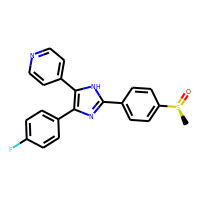
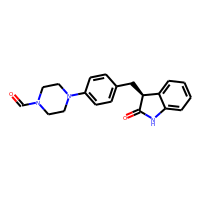

In [10]:
original_ligands = pd.read_csv('../data/fragment_library/original_ligands.csv')
PandasTools.AddMoleculeColumnToFrame(original_ligands, 'smiles')

print(original_ligands.shape)
original_ligands.head(2)

## 3. Ligand occupancy across subpockets

Calculate the number of subpockets a ligand is occupying. (Here, it is not of interest how often a subpocket is occupied by a ligand. Thus, we keep only one entry per ligand and subpocket.)

In [11]:
n_subpockets_per_ligand = fragment_library_concat_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).first().reset_index().groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size()

In [12]:
n_subpockets_per_ligand_distribution = pd.concat(
    [
        n_subpockets_per_ligand.value_counts().sort_index().rename('ligand_count'),
        n_subpockets_per_ligand.value_counts(normalize=True).sort_index().rename('ligand_frequency')*100
    ],
    axis=1
)

In [13]:
print('Number of subpockets per ligand (distribution):')
n_subpockets_per_ligand_distribution

Number of subpockets per ligand (distribution):


,ligand_count,ligand_frequency
1,127,4.974540
2,719,28.162946
3,1350,52.878966
4,327,12.808461
5,29,1.135919
6,1,0.039170


**Creates Figure 3.A in manuscript**

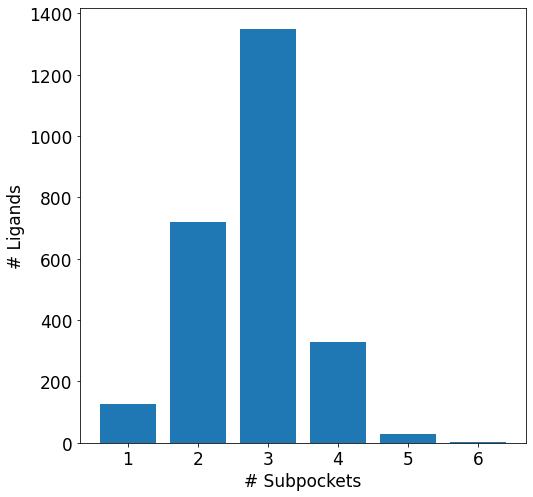

In [14]:
plot_n_subpockets(n_subpockets_per_ligand_distribution)

### Examples for a few special cases of ligands/fragments discussed in the manuscript

#### Ligands occupying 6 subpockets

Could equally be adapted to get samples for ligands occupying less subpockets.

In [15]:
ligand_of_interest_six = n_subpockets_per_ligand[n_subpockets_per_ligand == 6].reset_index()
ligand_of_interest_six

,kinase,complex_pdb,ligand_pdb,0
0,ALK,4fnz,NZF,6


**Creates Figure S1.A in supporting information**

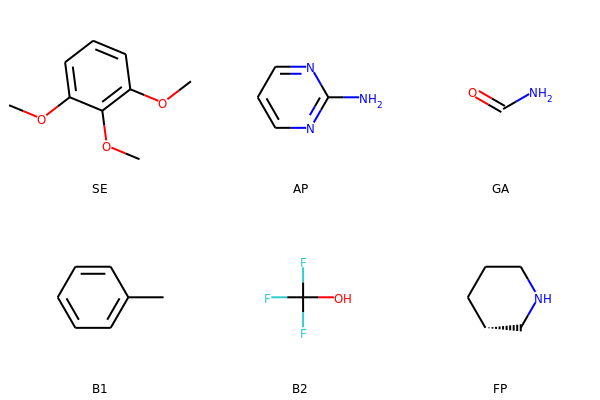

In [16]:
image_six_subpockets = draw_fragmented_ligand(
    fragment_library, 
    ligand_of_interest_six.complex_pdb.values[0], 
    ligand_of_interest_six.ligand_pdb.values[0],
    mols_per_row=3
)
image_six_subpockets.save(f'figures/extreme_subpockets_six_fragments.png')
image_six_subpockets

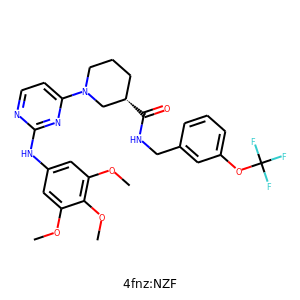

In [17]:
pdb_ids = ['4fnz']
image_ligand_from_pdb_ids = draw_ligands_from_pdb_ids(pdb_ids, sub_img_size=(300,300))
image_ligand_from_pdb_ids.save(f'figures/extreme_subpockets_six_ligand.png')
image_ligand_from_pdb_ids

#### Unfragmented ligands

Collect all ligands that only cover one subpocket.

In [18]:
ligand_of_interest_one = n_subpockets_per_ligand[n_subpockets_per_ligand == 1].reset_index()

In [19]:
# Get info for those ligands
unfragmented_ligands = []

for index, row in ligand_of_interest_one.iterrows():
    
    unfragmented_ligands.append(
        get_fragmented_ligand(
            fragment_library, 
            row.complex_pdb, 
            row.ligand_pdb
        )
    )
    
unfragmented_ligands = pd.concat(unfragmented_ligands)

In [20]:
unfragmented_ligands.shape

(127, 12)

In [21]:
n_heavy_atoms_unfragmented_fragments = unfragmented_ligands.apply(lambda x: x.ROMol.GetNumHeavyAtoms(), axis=1).mean()
n_heavy_atoms_ap_fragments = fragment_library['AP'].apply(lambda x: x.ROMol.GetNumHeavyAtoms(), axis=1).mean()

print(f'Mean number of heavy atoms in unfragmented ligands: {n_heavy_atoms_unfragmented_fragments}')
print(f'Mean number of heavy atoms in AP fragments: {n_heavy_atoms_ap_fragments}')

Mean number of heavy atoms in unfragmented ligands: 15.346456692913385
Mean number of heavy atoms in AP fragments: 11.005466614603671


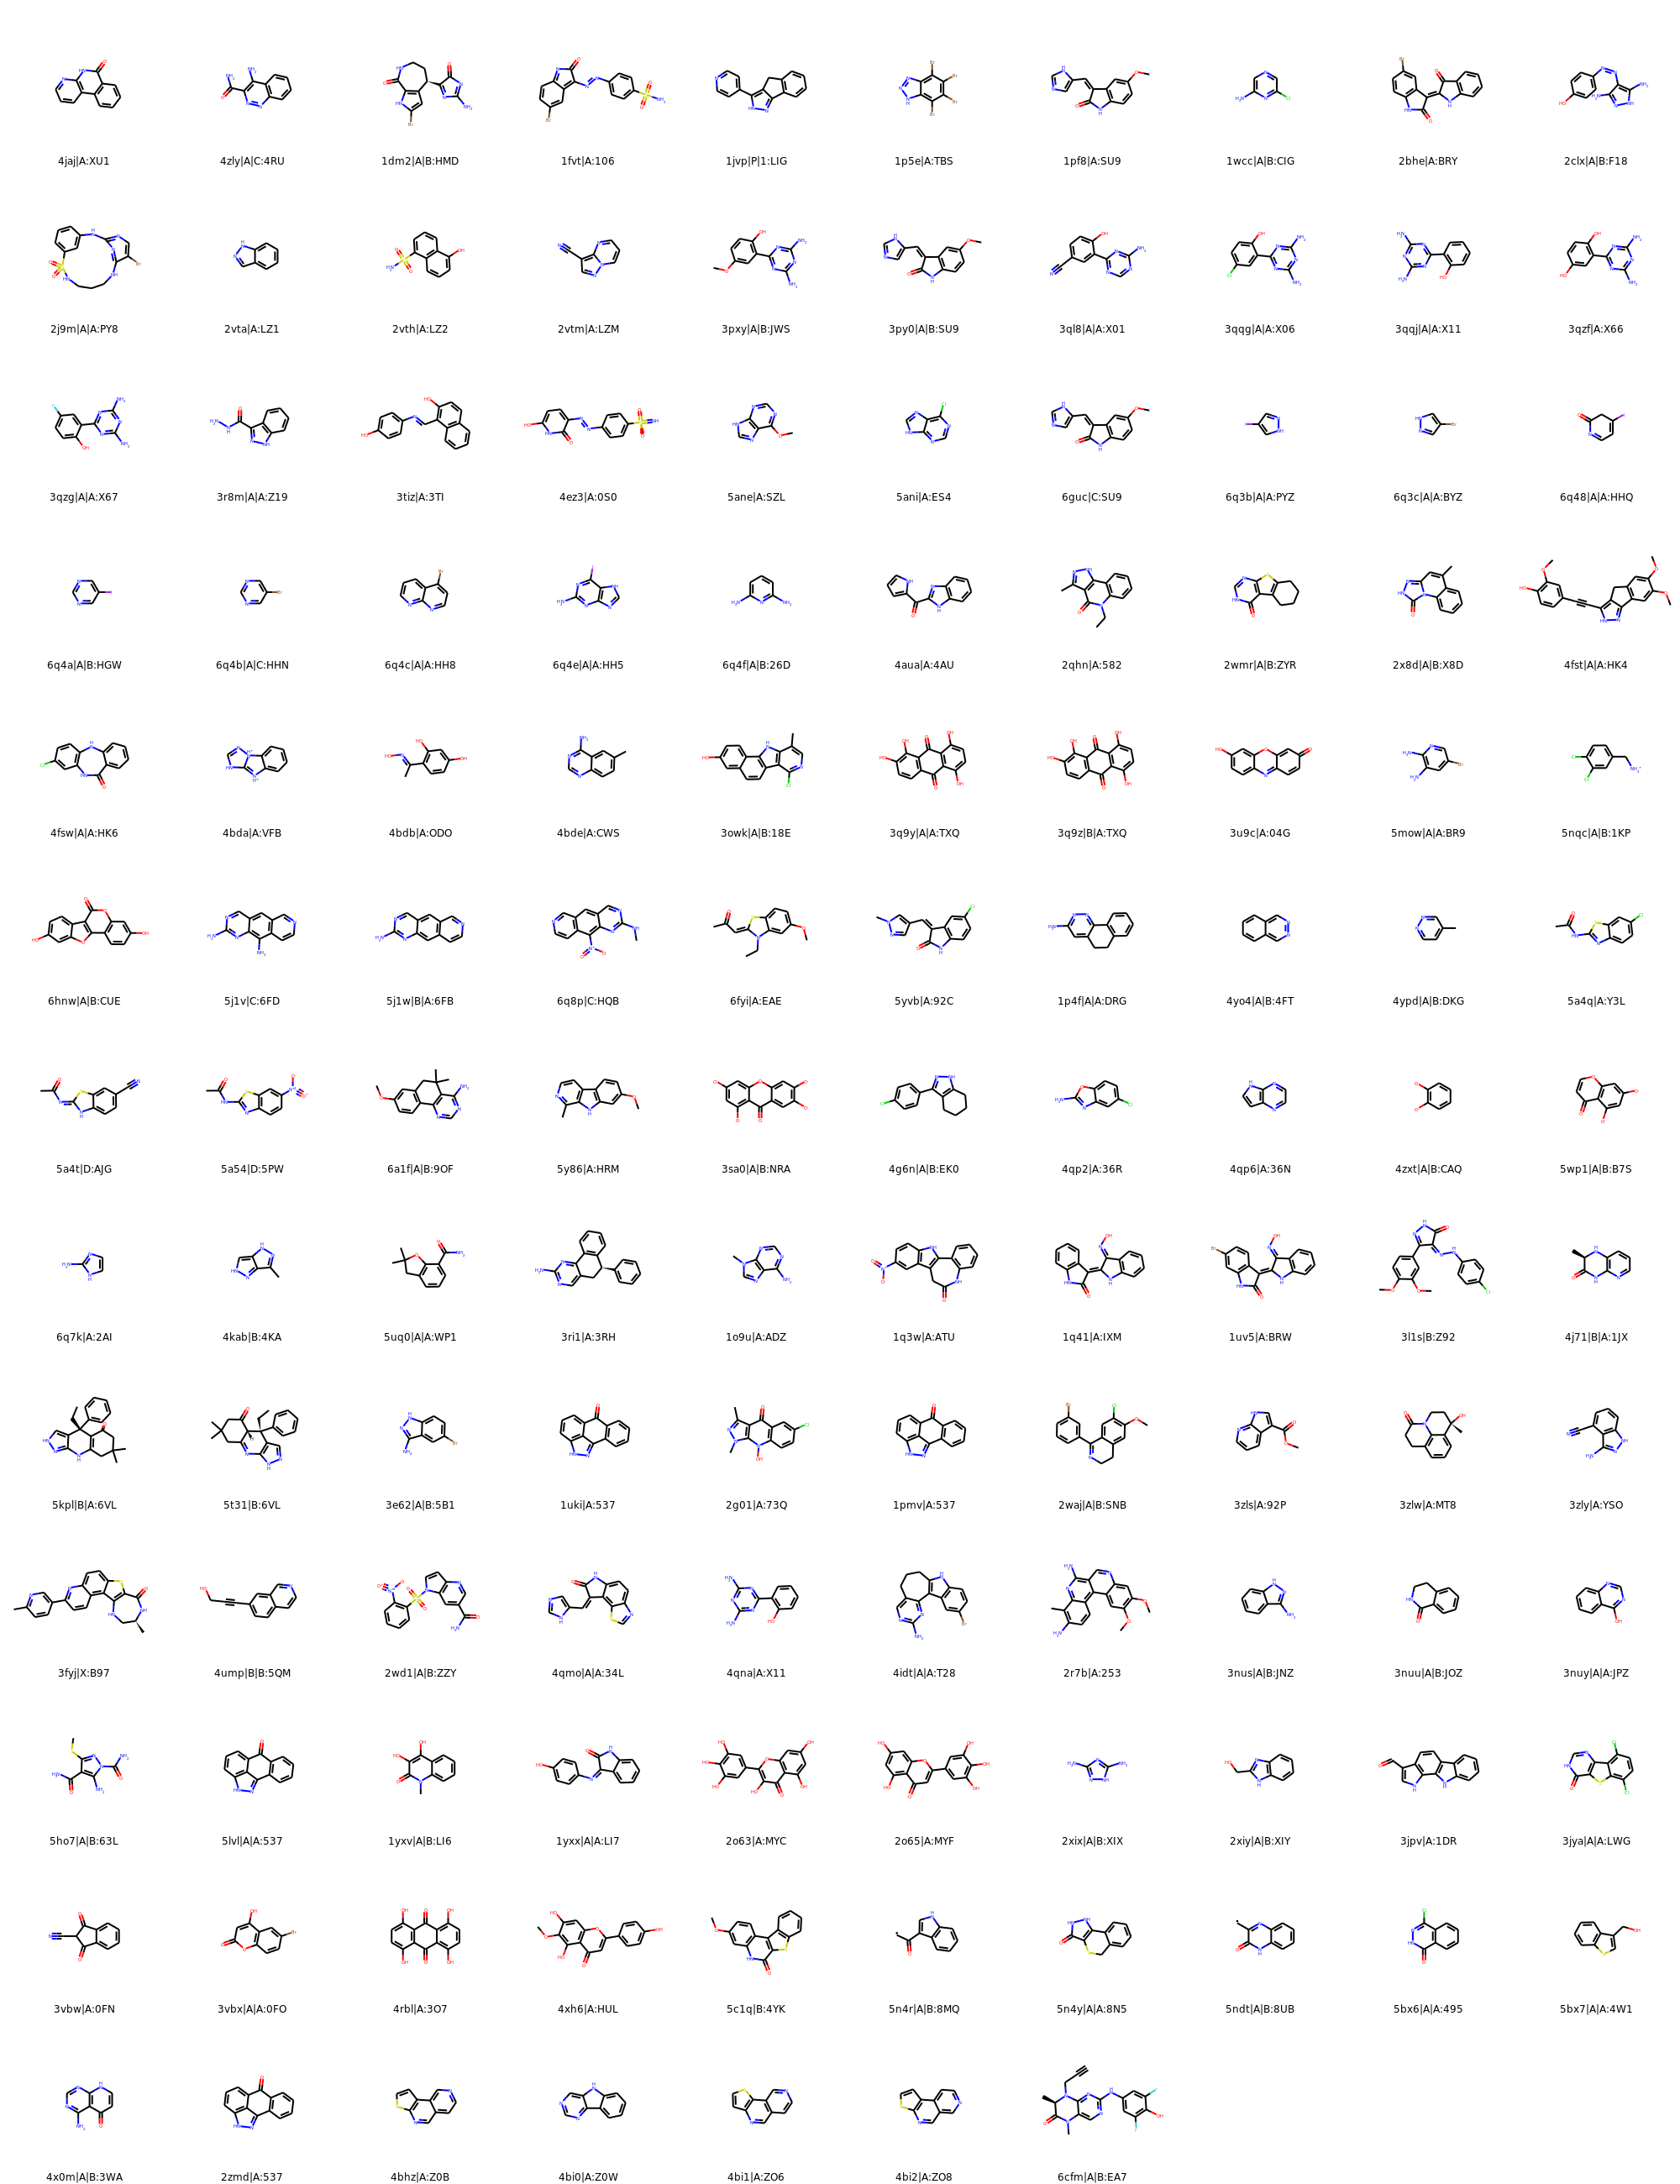

In [22]:
# Draw and save those ligands
image_unfragmented = draw_fragments(unfragmented_ligands, mols_per_row=10)
image_unfragmented.save(f'figures/extreme_subpockets_one.png')
image_unfragmented

#### Unfragmented ligands are substructures of other original ligands?

In [23]:
# Takes 1-2 minutes
unfragmented_in_original_ligands = []
unfragmented_as_substructure_in_original_ligands = []

for i, unfragmented_ligand in unfragmented_ligands.iterrows():
    for j, original_ligand in original_ligands.iterrows():
        
        template = original_ligand.ROMol
        pattern = unfragmented_ligand.ROMol
        match = template.HasSubstructMatch(pattern)

        if match:
            substructure = template.GetSubstructMatch(pattern)

            # Unfragmented ligand is the full original ligand
            if len(substructure) == template.GetNumAtoms():
                unfragmented_in_original_ligands.append([i, pattern, j, template, substructure])
            
            # Unfragmented ligand is substructure of original ligand
            else:
                unfragmented_as_substructure_in_original_ligands.append([i, pattern, j, template, substructure])
                
unfragmented_in_original_ligands = pd.DataFrame(
    unfragmented_in_original_ligands, 
    columns=['fragment_ix', 'fragment', 'ligand_ix', 'ligand', 'substructure']
)

unfragmented_as_substructure_in_original_ligands = pd.DataFrame(
    unfragmented_as_substructure_in_original_ligands, 
    columns=['fragment_ix', 'fragment', 'ligand_ix', 'ligand', 'substructure']
)

**Unfragmented ligands in original ligands**

Did the substructure search find all original ligands that were not fragmented?

In [24]:
print(f'Number of unfragmented ligands: {len(unfragmented_ligands)}')
print(f'Number of unfragmented ligands that were found in original ligands (sanity check): {len(unfragmented_in_original_ligands.fragment_ix.unique())}')

Number of unfragmented ligands: 127
Number of unfragmented ligands that were found in original ligands (sanity check): 127


**Unfragmented ligands that are substructures of other original ligands**

In [25]:
unfragmented_as_substructure_in_original_ligands_unique = unfragmented_as_substructure_in_original_ligands.groupby("fragment_ix").first().reset_index()

In [26]:
print(f'Number of unfragmented ligands that are substructure of original ligands: '
      f'{unfragmented_as_substructure_in_original_ligands_unique.shape[0]}'
)
print(f'Percentage of unfragmented ligands that are substructure of original ligands: '
      f'{unfragmented_as_substructure_in_original_ligands_unique.shape[0] / len(unfragmented_ligands)}'
)

Number of unfragmented ligands that are substructure of original ligands: 35
Percentage of unfragmented ligands that are substructure of original ligands: 0.2755905511811024


**Are these substructures fragment-like?**

In [27]:
fragment_likeness = [
    get_fragment_likeness_from_mol(row.fragment) 
    for index, row 
    in unfragmented_as_substructure_in_original_ligands_unique.iterrows()
]
fragment_likeness = pd.concat(fragment_likeness, axis=1).transpose()
fragment_likeness.head()

# Number of fulfilled rules (all rules)
fragment_likeness['n_fulfilled_extended'] = fragment_likeness.apply(sum, axis=1)

# Number of fulfilled rules (only basic rules: mw, logp, hbd, hba)
fragment_likeness['n_fulfilled_basic'] = fragment_likeness.apply(lambda x: x.mw + x.logp + x.hba + x.hbd, axis=1)

fragment_likeness.head()

,mw,logp,hbd,hba,nrot,psa,n_fulfilled_extended,n_fulfilled_basic
0,1,1,1,0,1,0,4,3
1,0,0,1,1,1,1,4,2
2,1,1,1,1,1,1,6,4
3,1,1,1,1,1,1,6,4
4,1,1,1,1,1,1,6,4


In [28]:
print(f'Ratio of unfragmented ligands (that are substructures of other ligands) that are fragment-like (fulfill RO3 for mw, logp and hba/d): '
      f'{fragment_likeness.groupby("n_fulfilled_basic").size()[4] / fragment_likeness.shape[0]}'
)

Ratio of unfragmented ligands (that are substructures of other ligands) that are fragment-like (fulfill RO3 for mw, logp and hba/d): 0.5714285714285714


Labels refer to " unfragmented ligand index | number of fulfilled RO3 rules (mw, logp, hba/d, psa, nrot) | number of fulfilled RO3 rules (mw, logp, hba/d)"


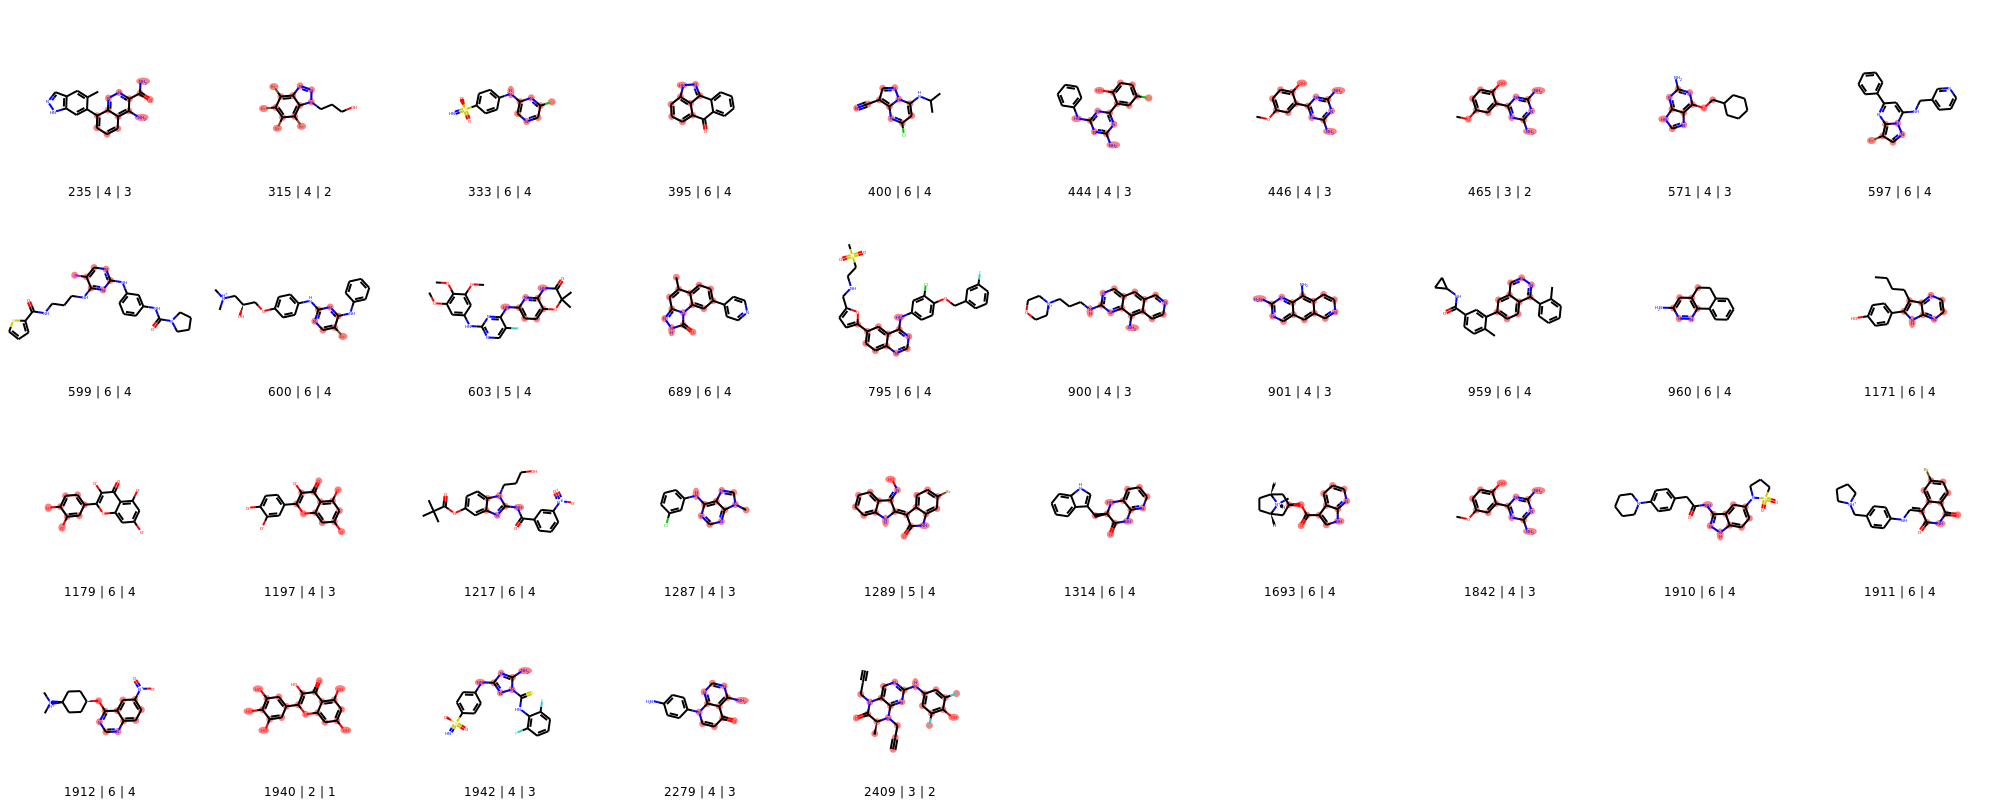

In [29]:
mols = list(unfragmented_as_substructure_in_original_ligands_unique.ligand)
highlight_atom_lists = list(unfragmented_as_substructure_in_original_ligands_unique.substructure)
legends = [
    f'{fragment_ix} | {n_fulfilled_ro3_extended} | {n_fulfilled_ro3_basic}' 
    for fragment_ix, n_fulfilled_ro3_extended, n_fulfilled_ro3_basic
    in zip(
        list(unfragmented_as_substructure_in_original_ligands_unique.fragment_ix), 
        list(fragment_likeness['n_fulfilled_extended']), 
        list(fragment_likeness['n_fulfilled_basic'])
    )
]

print(f'Labels refer to " unfragmented ligand index | number of fulfilled RO3 rules (mw, logp, hba/d, psa, nrot) | number of fulfilled RO3 rules (mw, logp, hba/d)"')

Draw.MolsToGridImage(
    mols, 
    highlightAtomLists=highlight_atom_lists,
    legends=legends,
    molsPerRow=10
)

#### Examples for unfragmented ligands in paper

**Creates Figure S1.B-D in supporting information**

In [30]:
unfragmented_ligands_paper_b = [
    ['6q3b', 'PYZ'], 
    ['6q3c', 'BYZ'], 
    ['6q48', 'HHQ'],
    ['6q4a', 'HGW'],
    ['6q4b', 'HHN'], 
    ['6q4c', 'HH8'],
    ['6q4e', 'HH5'],
    ['6q4f', '26D']
]
unfragmented_ligands_paper_c = [
    ['3q9y', 'TXQ'],
    ['5j1w', '6FB'],
    ['2o63', 'MYC']
]
unfragmented_ligands_paper_d = [
    ['4fst', 'HK4'],
    ['3fyj', 'B97'],
    ['6cfm', 'EA7']
]

**(B1-B8) Fragment-like ligands**

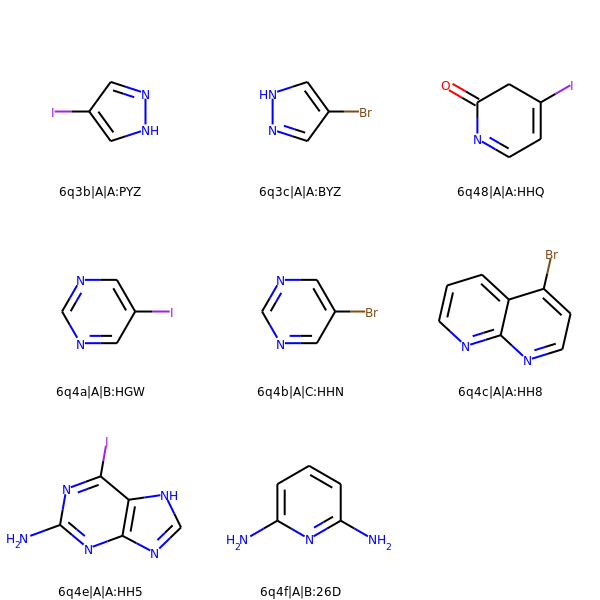

In [31]:
image_unfragmented_paper_b = draw_selected_fragments(
    unfragmented_ligands_paper_b, 
    unfragmented_ligands
)
image_unfragmented_paper_b.save(f'figures/extreme_subpockets_one_paper_b.png')
image_unfragmented_paper_b

**(C1-C3) Rigid/many fused rings containing ligands**

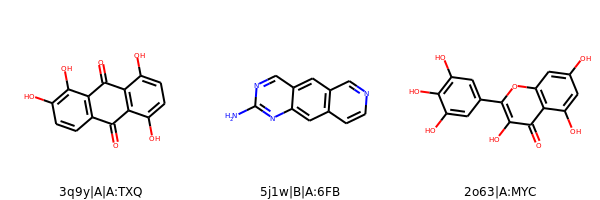

In [32]:
image_unfragmented_paper_c = draw_selected_fragments(
    unfragmented_ligands_paper_c, 
    unfragmented_ligands
)
image_unfragmented_paper_c.save(f'figures/extreme_subpockets_one_paper_c.png')
image_unfragmented_paper_c

**(D1-D3) Other larger unfragmented ligands**

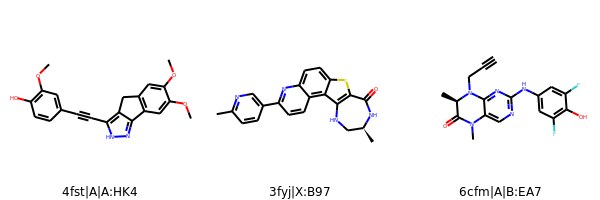

In [33]:
image_unfragmented_paper_d = draw_selected_fragments(
    unfragmented_ligands_paper_d, 
    unfragmented_ligands
)
image_unfragmented_paper_d.save(f'figures/extreme_subpockets_one_paper_d.png')
image_unfragmented_paper_d

## 4. Subpocket connectivity across subpockets

What subpocket connections do we see how often (connection as in a connection between 2 subpockets)? 

Respective information is stored in 'connections' column of `connections_by_fragment` (for all fragments in all subpockets except pool X).

### Connections per fragment

In [34]:
connections_by_fragment = get_connections_by_fragment(fragment_library_concat_wo_x)
connections_by_fragment.head()

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
0,AAK1,5l4q,LKB,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,"[FP, SE]","[AP=FP, AP=SE]",AP
1,AAK1,5te0,XIN,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, GA]","[AP=SE, AP=GA]",AP
2,ABL1,2f4j,VX6,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,[SE],[AP=SE],AP
3,ABL1,2gqg,1N1,AP AP AP AP AP AP AP AP AP AP GA SE,"[GA, SE]","[AP=GA, AP=SE]",AP
4,ABL1,2v7a,627,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, FP]","[AP=SE, AP=FP]",AP


Side note: Get all fragments that are connecting to the same subpocket multiple times.

In [35]:
fragments_connecting_to_same_subpocket = connections_by_fragment[
    connections_by_fragment.apply(
        lambda x: len(x.connections) != len(set(x.connections)),
        axis=1
    )
]

print(f'Number of fragments that have connections into the same subpocket multiple times: {len(fragments_connecting_to_same_subpocket)}')
fragments_connecting_to_same_subpocket.head()

Number of fragments that have connections into the same subpocket multiple times: 74


,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
10,ACK,4ewh,T77,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[FP, SE, FP]","[AP=FP, AP=SE, AP=FP]",AP
124,AurA,4dhf,0K6,AP AP AP AP AP AP AP AP AP AP AP AP AP SE FP FP,"[SE, FP, FP]","[AP=SE, AP=FP, AP=FP]",AP
214,BRK,5da3,58V,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, SE]","[AP=SE, AP=SE]",AP
325,CDK2,1pye,PM1,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[FP, FP]","[AP=FP, AP=FP]",AP
623,CDK6,5l2t,6ZZ,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[FP, GA, FP]","[AP=FP, AP=GA, AP=FP]",AP


### Connection frequencies

In [36]:
connections_by_ligand = get_connections_by_ligand(fragment_library_concat_wo_x)
connections_by_ligand.head()

group  complex_pdb  ligand_pdb
AGC    1z5m         LI8           {AP=FP, AP=SE}
       2esm         M77                  {AP=FP}
       2etk         HFS                  {AP=FP}
       2etr         Y27                  {AP=FP}
       2gu8         796                  {AP=FP}
Name: connections_name, dtype: object

In [37]:
connections = get_connections_count_by_ligand(connections_by_ligand)
connections

,count,frequency
AP=FP,1569,61.5
AP=SE,1502,58.8
AP=GA,920,36.0
FP=GA,198,7.8
FP=SE,196,7.7
SE=X-SE,125,4.9
FP=X-B2,99,3.9
B1=GA,94,3.7
B2=GA,84,3.3
FP=X-FP,22,0.9


## 5. Fragments occurrence per subpocket

### Deduplicated fragments (per subpocket)

Deduplicate fragmentes per subpocket based on their SMILES.

In [38]:
# Collect all fragments and deduplicated version of them
n_fragments_per_subpocket = [len(fragments) for subpocket, fragments in fragment_library.items()]
n_fragments_per_subpocket_deduplicated = [len(fragments.drop_duplicates('smiles')) for subpocket, fragments in fragment_library.items()]

In [39]:
# Get fragments numbers per subpocket
stats_n_fragments = pd.DataFrame(
    {
        'n_fragments': n_fragments_per_subpocket,
        'n_fragments_deduplicated': n_fragments_per_subpocket_deduplicated,
        'freq_duplicates': [(i-j) / i * 100 for i, j in zip(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)]
    },
    index=fragment_library.keys()
)
stats_n_fragments

,n_fragments,n_fragments_deduplicated,freq_duplicates
AP,2561,1115,56.462319
FP,1866,864,53.697749
SE,1560,607,61.089744
GA,1024,306,70.117188
B1,98,42,57.142857
B2,92,43,53.260870
X,285,110,61.403509


In [40]:
print(f'Mean duplicates frequency across subpockets: {stats_n_fragments.freq_duplicates.mean()}')

Mean duplicates frequency across subpockets: 59.02489073891017


In [41]:
pd.DataFrame(
    {
        'freq_fragments': [i / sum(n_fragments_per_subpocket[:-1]) * 100 for i in n_fragments_per_subpocket[:-1]],
        'freq_fragments_deduplicated': [i / sum(n_fragments_per_subpocket_deduplicated[:-1]) * 100 for i in n_fragments_per_subpocket_deduplicated[:-1]]
    },
    index=list(fragment_library.keys())[:-1]
)

,freq_fragments,freq_fragments_deduplicated
AP,35.564505,37.453813
FP,25.913068,29.022506
SE,21.663658,20.389654
GA,14.220247,10.278804
B1,1.360922,1.410816
B2,1.277600,1.444407


In [42]:
print(f'Number of fragments (wo X): {sum(n_fragments_per_subpocket[:-1])}')
print(f'Number of deduplicated fragments (wo X): {sum(n_fragments_per_subpocket_deduplicated[:-1])}')

Number of fragments (wo X): 7201
Number of deduplicated fragments (wo X): 2977


**Creates Figure 3.B in manuscript**

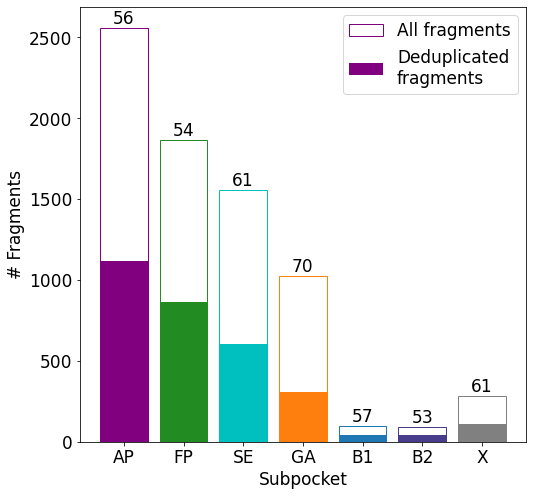

In [43]:
plot_n_fragments_per_subpocket(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)

### Ligands with multiple fragments per subpocket

Ligands can occupy subpocket(s) multiple times. Let's check how often this happens for which subpockets.

Get for each ligand the number of fragments in each subpocket.

In [44]:
n_fragments_per_subpocket_per_ligand = fragment_library_concat_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).size()
n_fragments_per_subpocket_per_ligand.name = 'n_fragments'
n_fragments_per_subpocket_per_ligand.head()

kinase  complex_pdb  ligand_pdb  subpocket
AAK1    5l4q         LKB         AP           1
                                 FP           1
                                 SE           1
        5te0         XIN         AP           1
                                 GA           1
Name: n_fragments, dtype: int64

Per subpocket, how many ligands have subpockets covered with one or multiple ligands?

In [45]:
n_fragments_per_subpocket_per_ligand.reset_index().groupby(['subpocket', 'n_fragments']).size()

subpocket  n_fragments
AP         1              2545
           2                 8
B1         1                96
           2                 1
B2         1                92
FP         1              1675
           2                94
           3                 1
GA         1              1020
           2                 2
SE         1              1520
           2                20
dtype: int64

## 6. Fragment properties per subpocket

### Duplicates

Discussed in *8. Fragment promiscuity*.

### Physicochemical properties

Get descriptors for fragments per subpocket (deduplicated per subpocket):

In [46]:
descriptors = get_descriptors_by_fragments(fragment_library)

In [47]:
descriptors.groupby('subpocket').median()

,# HBD,# HBA,LogP,# Heavy atoms
subpocket,,,,
AP,1.0,3.0,1.20420,12.0
B1,1.0,1.5,1.15670,7.5
B2,0.0,1.0,1.27960,9.0
FP,1.0,2.0,0.72930,10.0
GA,1.0,1.0,1.40790,9.0
SE,1.0,2.0,0.98540,11.0
X,1.0,1.0,0.43055,7.0


**Creates Figure 5.A in manuscript**

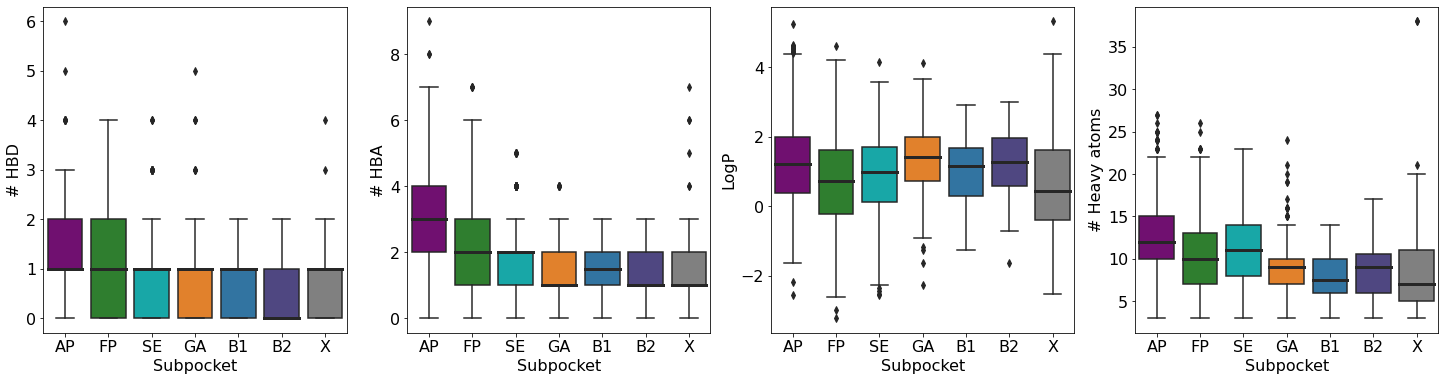

In [48]:
plot_fragment_descriptors(descriptors)

##### Some more details on the descriptor values per subpocket

In [49]:
descriptors.groupby('subpocket')['# HBD'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,1.286996,0.880754,0.0,1.0,1.0,2.0,6.0
B1,42.0,0.595238,0.543679,0.0,0.0,1.0,1.0,2.0
B2,43.0,0.534884,0.701998,0.0,0.0,0.0,1.0,2.0
FP,864.0,1.144676,0.888262,0.0,0.0,1.0,2.0,4.0
GA,306.0,0.820261,0.835904,0.0,0.0,1.0,1.0,5.0
SE,607.0,0.876442,0.812173,0.0,0.0,1.0,1.0,4.0
X,110.0,0.772727,0.725159,0.0,0.0,1.0,1.0,4.0


In [50]:
descriptors.groupby('subpocket')['# HBA'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,3.081614,1.446091,0.0,2.0,3.0,4.0,9.0
B1,42.0,1.380952,0.763573,0.0,1.0,1.5,2.0,3.0
B2,43.0,1.348837,0.783269,0.0,1.0,1.0,2.0,3.0
FP,864.0,1.958333,1.270259,0.0,1.0,2.0,3.0,7.0
GA,306.0,1.500000,0.927715,0.0,1.0,1.0,2.0,4.0
SE,607.0,1.751236,1.060416,0.0,1.0,2.0,2.0,5.0
X,110.0,1.454545,1.324687,0.0,1.0,1.0,2.0,7.0


In [51]:
descriptors.groupby('subpocket')['LogP'].describe().sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
X,110.0,0.637483,1.481660,-2.5223,-0.404825,0.43055,1.616925,5.30610
FP,864.0,0.678346,1.315180,-3.2074,-0.216122,0.72930,1.611725,4.60112
SE,607.0,0.878808,1.190076,-2.5398,0.113200,0.98540,1.703800,4.13230
B1,42.0,1.073996,1.028205,-1.2485,0.294535,1.15670,1.683875,2.90130
AP,1115.0,1.255060,1.169443,-2.5461,0.392100,1.20420,1.990235,5.23640
B2,43.0,1.234849,0.926753,-1.6339,0.593900,1.27960,1.947360,3.00630
GA,306.0,1.341928,0.994495,-2.2714,0.730022,1.40790,1.991490,4.11040


In [52]:
descriptors.groupby('subpocket')['# Heavy atoms'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,12.596413,4.004529,3.0,10.0,12.0,15.0,27.0
B1,42.0,8.071429,2.982820,3.0,6.0,7.5,10.0,14.0
B2,43.0,8.813953,3.560737,3.0,6.0,9.0,10.5,17.0
FP,864.0,10.539352,4.279984,3.0,7.0,10.0,13.0,26.0
GA,306.0,8.908497,3.182657,3.0,7.0,9.0,10.0,24.0
SE,607.0,10.859967,4.072588,3.0,8.0,11.0,14.0,23.0
X,110.0,8.736364,5.885260,3.0,5.0,7.0,11.0,38.0


## 7. Fragment similarity per subpockets

1. Group and deduplicate all fragments by subpocket.
2. Calculate similarities for all pairwise fragment combinations within subpockets.

In [53]:
similarities_per_subpocket = get_fragment_similarity_per_subpocket(fragment_library_concat)
similarities_per_subpocket.head()

,similarity,subpocket
0,0.104987,AP
1,0.108247,AP
2,0.059072,AP
3,0.198225,AP
4,0.170306,AP


**Creates Figure 5.B in manuscript**

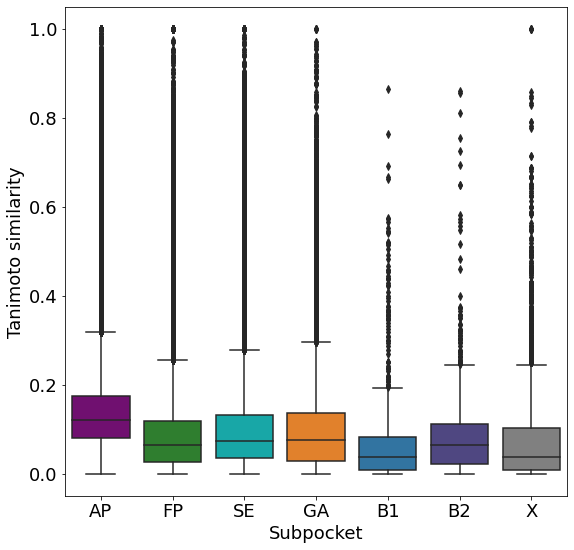

In [54]:
plot_fragment_similarity(similarities_per_subpocket, 'Subpocket')

In [55]:
similarities_per_subpocket.groupby('subpocket', sort=False).mean()

,similarity
subpocket,
AP,0.139185
FP,0.089188
SE,0.102719
GA,0.104821
B1,0.074256
B2,0.088506
X,0.077704


In [56]:
{key: len(value) for key, value in fragment_library.items()}

{'AP': 2561, 'FP': 1866, 'SE': 1560, 'GA': 1024, 'B1': 98, 'B2': 92, 'X': 285}

## 8. Fragment promiscuity

### Fragment similarity between and across kinase groups

Are fragments more similar within kinase groups than across kinase groups?

1. Group and deduplicate all fragments by kinase group and subpocket (excluding pool X).
2. Calculate similarities for all pairwise fragment combinations within kinase groups and subpockets (excluding X).
4. Calculate total distribution across all kinase groups (i.e. get all similarities by kinase groups and subpockets for the new kinase group 'Total').

In [57]:
similarities_per_kinase_group = get_fragment_similarity_per_kinase_group(fragment_library_concat_wo_x)
similarities_per_kinase_group.head()

,similarity,group,subpocket
0,0.530864,AGC,AP
1,0.527607,AGC,AP
2,0.464865,AGC,AP
3,0.643411,AGC,AP
4,0.166065,AGC,AP


In [58]:
similarities_per_kinase_group.groupby('group').size()

group
AGC        7666
CAMK      53287
CK1         986
CMGC     148712
Other     22433
STE        5844
TK       135443
TKL       10476
Total    384847
dtype: int64

**Creates Figure 5.C in manuscript**

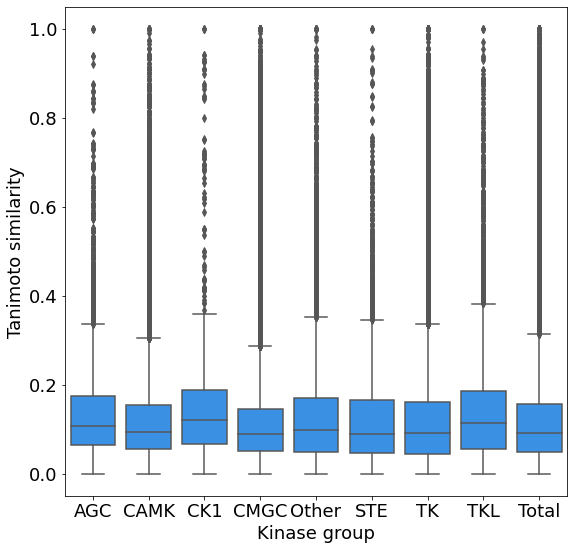

In [59]:
plot_fragment_similarity(similarities_per_kinase_group, 'Kinase group')

In [60]:
similarities_per_kinase_group.groupby('group', sort=False).mean()

,similarity
group,
AGC,0.134660
CAMK,0.119845
CK1,0.160031
CMGC,0.111484
Other,0.126572
STE,0.123428
TK,0.119414
TKL,0.137443
Total,0.117786


### Singleton fragments

Analyze which fragments appear only once or several times in each subpocket.

In [61]:
fragment_occurrence = fragment_library_concat.groupby(['subpocket', 'smiles']).size()
fragment_occurrence.head()

subpocket  smiles                      
AP         Brc1c(Br)c(Br)c2[nH]cnc2c1Br    2
           Brc1c(Br)c(Br)c2[nH]nnc2c1Br    4
           Brc1c(Br)c(Br)c2n[nH]nc2c1Br    2
           Brc1ccc2[nH]ccc2c1              1
           Brc1ccc2occc2c1                 2
dtype: int64

In [62]:
# Collect numbers
singletons = pd.DataFrame(
    {
        '# singletons': fragment_occurrence[fragment_occurrence == 1].reset_index().groupby('subpocket').size(),
        '# duplicated fragments': fragment_occurrence[fragment_occurrence > 1].reset_index().groupby('subpocket').size(),
        '# deduplicated fragments': fragment_occurrence.reset_index().groupby('subpocket').size()
    }
)
singletons['% singletons'] = singletons['# singletons'] / singletons['# deduplicated fragments'] * 100
singletons

,# singletons,# duplicated fragments,# deduplicated fragments,% singletons
subpocket,,,,
AP,762,353,1115,68.340807
B1,29,13,42,69.047619
B2,27,16,43,62.790698
FP,607,257,864,70.254630
GA,181,125,306,59.150327
SE,397,210,607,65.403624
X,68,42,110,61.818182


In [63]:
print(f"Average ratio of singletons across subpockets: {singletons.drop('X')['% singletons'].mean()}")

Average ratio of singletons across subpockets: 65.8312841176914


In [64]:
singletons.sum()

# singletons                2071.000000
# duplicated fragments      1016.000000
# deduplicated fragments    3087.000000
% singletons                 456.805887
dtype: float64

### Duplicate fragments

Analyze if fragments that appear several times (duplicate fragments) bind to the same or different kinases (or even across kinase groups).

Group fragments by subpocket and their SMILES. This deduplicates the dataset per subpocket based on the fragment SMILES.

In [65]:
# Retain information on kinase and group during deduplication
fragments_by_subpocket_and_smiles = pd.concat(
    [
        fragment_library_concat.groupby(['subpocket', 'smiles'])['kinase'].apply(list), 
        fragment_library_concat.groupby(['subpocket', 'smiles'])['group'].apply(list)
    ], 
    axis=1
)
fragments_by_subpocket_and_smiles.head()

kinase  \
subpocket smiles                                                      
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br               [CK2a1, CK2a1]   
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br  [CDK2, CK2a1, CK2a2, CK2a2]   
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br               [CK2a1, CK2a1]   
          Brc1ccc2[nH]ccc2c1                                 [PIM1]   
          Brc1ccc2occc2c1                              [PIM1, PIM1]   

                                                           group  
subpocket smiles                                                  
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br              [CMGC, CMGC]  
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br  [CMGC, CMGC, CMGC, CMGC]  
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br              [CMGC, CMGC]  
          Brc1ccc2[nH]ccc2c1                              [CAMK]  
          Brc1ccc2occc2c1                           [CAMK, CAMK]

Per deduplicated fragment save all kinases and kinase groups. 
This allows to track the following:

1. How many deduplicated fragments are there (within each subpocket)?
2. How many fragments (within subpockets) are singletons?
3. How many fragments (within subpockets) are duplicates?
4. From the duplicates, how many bind to the same kinase?
5. From the duplicates, how many bind to different kinases?
6. From the duplicates binding to different kinases, how many bind to the same kinase group?
7. From the duplicates binding to different kinases, how many to different kinase groups?

**1. How many deduplicated fragments are there (within each subpocket)?**

In [66]:
fragments_deduplicated = fragments_by_subpocket_and_smiles
fragments_deduplicated.shape[0]

3087

**2. How many fragments (within subpockets) are singletons?**

In [67]:
fragments_singletons = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: len(x.kinase) == 1,
        axis=1
    )
]
fragments_singletons.shape[0]

2071

**3. How many fragments (within subpockets) are duplicates?**

In [68]:
fragments_duplicates = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: len(x.kinase) != 1,
        axis=1
    )
]
fragments_duplicates.shape[0]

1016

**4. From the duplicates, how many bind to the same kinase?**

In [69]:
fragments_duplicates_same_kinase = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) == 1),
        axis=1
    )
]
fragments_duplicates_same_kinase.shape[0]

381

**5. From the duplicates, how many bind to different kinases?**

In [70]:
fragments_duplicates_different_kinases = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1),
        axis=1
    )
]
fragments_duplicates_different_kinases.shape[0]

635

**6. From the duplicates binding to different kinases, how many bind to the same kinase group?**

In [71]:
fragments_duplicates_different_kinases_same_group = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1) & (len(set(x.group)) == 1),
        axis=1
    )
]
fragments_duplicates_different_kinases_same_group.shape[0]

155

**7. From the duplicates binding to different kinases, how many to different kinase groups?**

In [72]:
fragments_duplicates_different_kinases_and_group = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1) & (len(set(x.group)) != 1),
        axis=1
    )
]
fragments_duplicates_different_kinases_and_group.shape[0]

480

**Summarize numbers**

Note: The DataFrames shown below where created in steps 1-7 above.

In [73]:
stats = pd.DataFrame(
    [
        fragments_deduplicated.reset_index().groupby('subpocket').size(),
        fragments_singletons.reset_index().groupby('subpocket').size(),
        fragments_duplicates.reset_index().groupby('subpocket').size(),
        fragments_duplicates_same_kinase.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases_same_group.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases_and_group.reset_index().groupby('subpocket').size(),
    ],
    index=[
        'fragments_deduplicated',
        'fragments_singletons',
        'fragments_duplicates',
        'fragments_duplicates_same_kinase',
        'fragments_duplicates_different_kinases',
        'fragments_duplicates_different_kinases_same_group',
        'fragments_duplicates_different_kinases_and_group',
    ]
)
stats

subpocket,AP,B1,B2,FP,GA,SE,X
fragments_deduplicated,1115,42,43,864,306,607,110
fragments_singletons,762,29,27,607,181,397,68
fragments_duplicates,353,13,16,257,125,210,42
fragments_duplicates_same_kinase,149,6,8,95,39,72,12
fragments_duplicates_different_kinases,204,7,8,162,86,138,30
fragments_duplicates_different_kinases_same_group,51,4,2,44,25,24,5
fragments_duplicates_different_kinases_and_group,153,3,6,118,61,114,25


In [74]:
stats.transpose().sum()

fragments_deduplicated                               3087
fragments_singletons                                 2071
fragments_duplicates                                 1016
fragments_duplicates_same_kinase                      381
fragments_duplicates_different_kinases                635
fragments_duplicates_different_kinases_same_group     155
fragments_duplicates_different_kinases_and_group      480
dtype: int64

In [75]:
print(
    f'Ratio of singletons \n(with respect to deduplicated fragments):\n'
    f'{fragments_singletons.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind only to one kinase \n(with respect to deduplicated fragments):\n'
    f'{fragments_duplicates_same_kinase.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind to different kinases and kinase groups \n(with respect to deduplicated fragments):\n'
    f'{fragments_duplicates_different_kinases_and_group.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind to different kinase groups \n(with respect to fragments that bind to different kinases):\n'
    f'{fragments_duplicates_different_kinases_and_group.shape[0] / fragments_duplicates_different_kinases.shape[0]}\n'
)

Ratio of singletons 
(with respect to deduplicated fragments):
0.6708778749595076

Ratio of duplicate fragments that bind only to one kinase 
(with respect to deduplicated fragments):
0.12342079689018465

Ratio of duplicate fragments that bind to different kinases and kinase groups 
(with respect to deduplicated fragments):
0.1554907677356657

Ratio of duplicate fragments that bind to different kinase groups 
(with respect to fragments that bind to different kinases):
0.7559055118110236



## 9. Miscellaneous

### Draw ligand and fragments for GitHub README figure

In [76]:
complex_pdb = '3w2s'
ligand_pdb = 'W2R'

,ROMol,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,subpocket
1039,,EGFR,EGFR,TK,3w2s,W2R,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,9 9 9 9 9 9 9 9 9 9 9 9 5 5 na na,Nc1ncnc2cc[nH]c12,AP
374,,EGFR,EGFR,TK,3w2s,W2R,A,A,GA GA GA GA GA GA GA GA GA GA GA B1 AP,16 16 16 16 16 16 16 16 16 3 16 na na,Oc1ccccc1Cl,GA
47,,EGFR,EGFR,TK,3w2s,W2R,A,A,B1 B1 B1 B1 B1 B1 B1 B1 B1 B1 GA B2,16 16 16 16 16 16 16 16 16 16 na na,c1ccccc1,B1
18,,EGFR,EGFR,TK,3w2s,W2R,A,A,B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B...,1 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15...,NC(=O)NC1CCCCC1,B2
737,,EGFR,EGFR,TK,3w2s,W2R,A,A,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,8 8 8 8 8 8 4 4 4 4 4 4 3 3 3 na,CCOCCO,FP

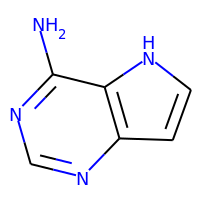
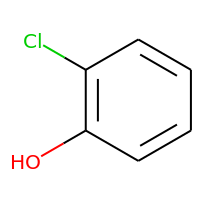
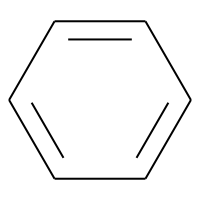
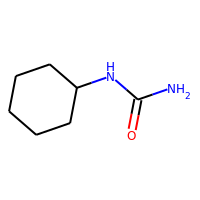
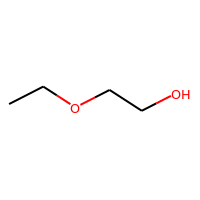

In [77]:
get_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb)

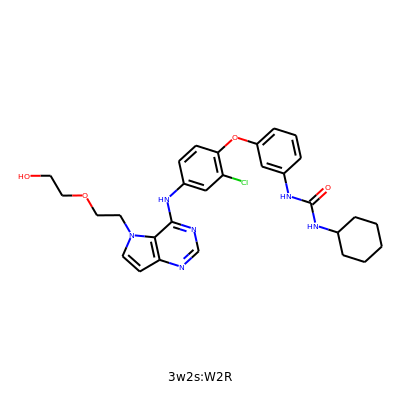

In [78]:
img = draw_ligands_from_pdb_ids([complex_pdb], sub_img_size=(400,400), mols_per_row=1)
img

In [79]:
img.save(f'figures/ligands_3w2s.png')

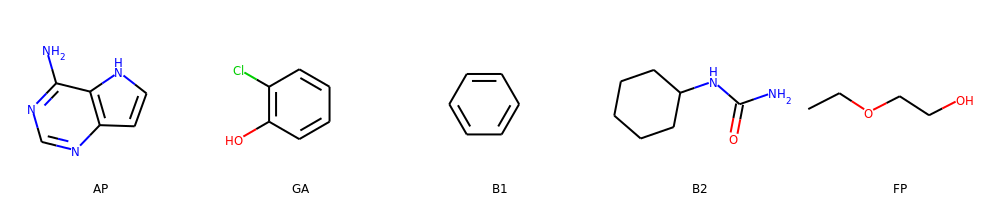

In [80]:
img = draw_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)
img

In [81]:
img.save(f'figures/fragments_3w2s_altA_chainA.png')

### Ligands occupying B1/B2 predominantly in aC-out/out-like conformations?

Goal: Compare ratio of aC-in/out/out-like ratio for back cleft binders (ligands with fragments in B1 and B2) against front cleft binders, in order to explain why we only have so little ligands reaching subpockets B1 and B2. If structures with ligands reaching B1 and B2 are enriched in the aC-out/out-like conformations, 

**KLIFS definitions for aC-in/out/out-like**: Distance between Ca atoms of D(xDFG.81) and E(aC.24)
* aC-in: 4-7.2 A
* aC-out: 9.3-14 A
* aC-out-like: distances in between

In [82]:
b1_or_b2_binders = original_ligands[original_ligands.subpocket.apply(lambda x: ('B1' in x) or ('B2' in x))]
b1_and_b2_non_binders = original_ligands[original_ligands.subpocket.apply(lambda x: ('B1' not in x) and ('B2' not in x))]

In [83]:
ac_conformations_stats = pd.concat(
    [
        original_ligands.groupby('ac_helix').size(),
        b1_and_b2_non_binders.groupby('ac_helix').size(),
        b1_or_b2_binders.groupby('ac_helix').size(),
    ],
    axis=1
)
ac_conformations_stats.rename(columns={0: 'all ligands', 1: 'not in b1 and b2', 2: 'in b1 or b2'}, inplace=True)


ac_conformations_stats

,all ligands,not in b1 and b2,in b1 or b2
in,1766,1722,44.0
na,2,2,NaN
out,543,461,82.0
out-like,242,189,53.0


In [84]:
ac_conformations_stats.sum()

all ligands         2553.0
not in b1 and b2    2374.0
in b1 or b2          179.0
dtype: float64

### Core fragments from Yang et al. publication in our dataset?

Check for the largest core fragments if they are in our dataset.

**Core fragments from Yang et al. publication (examples)**

,smiles,ROMol
0,C3=C2C(=O)N(C1(CCCCC1)N2C(C=C3)=O)[H],
1,C13=C(CCC2=CN=CN=C12)C=N[NH]3,

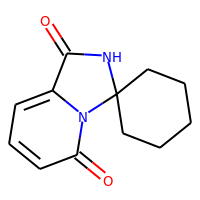
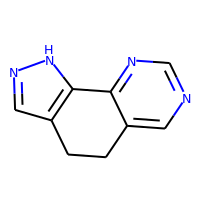

In [85]:
yang_mols = pd.DataFrame(
    [
        'C3=C2C(=O)N(C1(CCCCC1)N2C(C=C3)=O)[H]',
        'C13=C(CCC2=CN=CN=C12)C=N[NH]3'
    ],
    columns=['smiles']
)
PandasTools.AddMoleculeColumnToFrame(yang_mols, 'smiles')
yang_mols

**Are these molecules part of our original ligands?**

In [86]:
matches = {}

for i, mol in yang_mols.iterrows():
    matches[i] = []
    
    try:
        for j, original_ligand in original_ligands.iterrows():
            
            template = original_ligand.ROMol
            pattern = mol.ROMol
            match = template.HasSubstructMatch(pattern)
            if match:
                matches[i].append(original_ligand)
        
    except AttributeError:  # ROMol missing
        print(f'Original ligand {j} has no ROMol.')
        
    matches[i] = pd.concat(matches[i], axis=1).transpose()

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,ROMol
2294,6ck6,N45,"['AP', 'FP']",MNK2,MAPKAPK,CAMK,,A,out-like,Cc1cc(Nc2cc(N)ncn2)c(=O)n2c1C(=O)NC21CCCCC1,

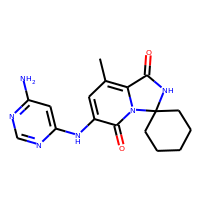

In [87]:
matches[0]

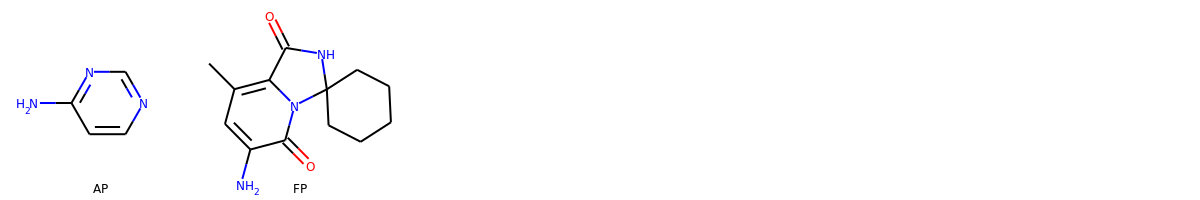

In [88]:
draw_fragmented_ligand(fragment_library, '6ck6', 'N45')

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,ROMol
341,2wip,P49,"['AP', 'SE', 'GA']",CDK2,CDK,CMGC,,C,in,Cn1nc(C(=O)[O-])c2c1-c1nc(Nc3ccccc3)ncc1CC2,
376,2x9e,SVE,"['AP', 'FP', 'SE', 'X']",TTK,TTK,Other,,A,in,CCc1cccc(CC)c1NC(=O)c1nn(C)c2c1CCc1cnc(Nc3ccc(...,

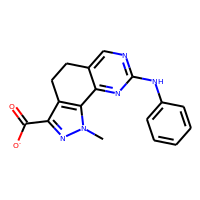
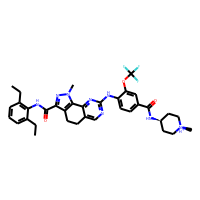

In [89]:
matches[1].head(2)

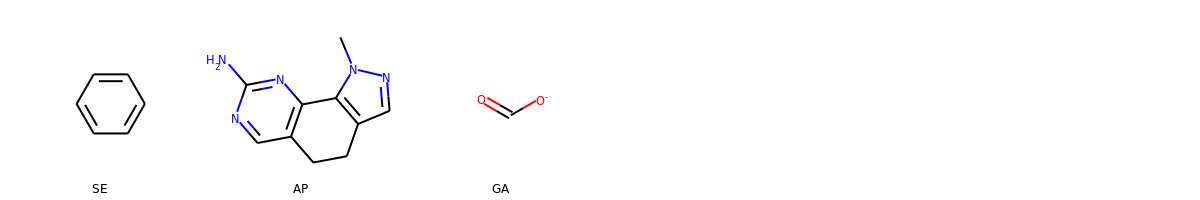

In [90]:
draw_fragmented_ligand(fragment_library, '2wip', 'P49')